Problem 2

Importing drive

Drive link: "https://drive.google.com/drive/folders/1g82mmWWTgTHt4xNHpAE88fLIhqnpGXso?usp=sharing"

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Importing required libraries

In [ ]:
import cv2
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
from sklearn.cluster import KMeans

Problem 1.

1. Image Collection:

In [ ]:
# images are read from the folder and are appended into a list
os.chdir("/content/drive/My Drive/ENPM673/Proj_3/New_folder")
files = os.listdir()
images = []
for i in files:
  imag = cv2.imread(i)
  images.append(imag)

2. Calibration Pipeline:

Step1: Declaring chessboard dimensions

Step2: Finding corners of the chessboard squares and refined using "cv2.cornerSubPix"

Step3: Using the refined points the camera is calibrated and the required camera parameters and matrices are found, the undistorted image is found

Step4: Points are projected using the calculated rotational and translational camera matrices

Step5: Reprojection error is calculated from the above found points and is plotted

Step6: The required visualizations are plotted

In [ ]:
# declaring the checkerboard dimensions
checker_board_h = 10
checker_board_w = 7
# forming an empty matrix
objp = np.zeros((1, 10*7, 3), np.float32)
objp[0,:,:2] = np.mgrid[0:10, 0:7].T.reshape(-1, 2)
threed_pts = []
twod_pts = []

In [ ]:
count = 0
pcount = 0
unblurr_wo_corner = []
unblurr = []
# itterating through each image to find the corners
for j in images:
  i = j.copy()
  # unblurr.append(i)
  pcount+=1
  gray_img = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
  bool_v,corner = cv2.findChessboardCorners(gray_img, (10,7), None)
  # checking for blurred images
  if bool_v == True:
    unblurr.append(i)
    unblurr_wo_corner.append(j)
    count+=1
    ref_corners = cv2.cornerSubPix(gray_img, corner, (11,11),(-1,-1), criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
    twod_pts.append(ref_corners)
    threed_pts.append(objp)
    corner_img = cv2.drawChessboardCorners(i, (10,7), ref_corners, bool_v)
    # cv2_imshow(corner_img)
print("Number of unblurred images",count)

Number of unblurred images 57


In [ ]:
# finding the camera parameters
ret, cam_mat, distortion, rot_vec, trans_vec = cv2.calibrateCamera(threed_pts, twod_pts, gray_img.shape[::-1], None, None)
test_img = unblurr[20]
# getting optimised camera matrix
new_cam_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, distortion, (test_img.shape[1],test_img.shape[0]), 1, (test_img.shape[1],test_img.shape[0]))
print("Camera matrix: ",cam_mat)
print("\n\n")
print("Distortion matrix: ",distortion)

Camera matrix:  [[2.21774522e+03 0.00000000e+00 9.38752577e+02]
 [0.00000000e+00 2.21016080e+03 5.12459929e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]



Distortion matrix:  [[-0.04189622  0.52927964 -0.00310064 -0.00196967 -1.60862071]]


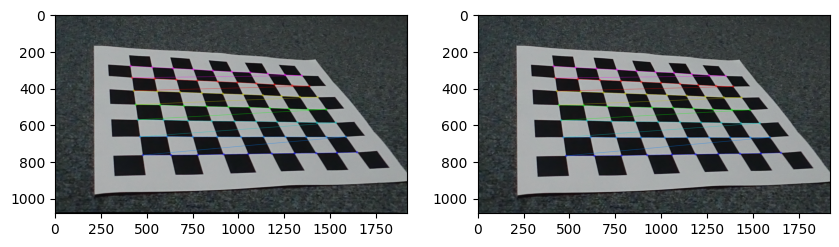

In [ ]:
# using the camera parameters to get undistorted image
undist_img = cv2.undistort(test_img, cam_mat, distortion, None, new_cam_mat)
# undist_img = undist_img[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
# cv2_imshow(undist_img)
# plotting the ditorted and undistorted image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(undist_img)
plt.title('Undistorted Img')
plt.subplot(1, 2, 2)
plt.imshow(test_img)
plt.title('Original Img')
plt.show()

Since the original image itself has a very little distortion, the undistorted image has a negligible transformation comparitively. If the original image has a fish eye effeect (if took from a raspberrypi cam), it might had a considerabe transformation.

3. Reprojection Error Analysis:

In [ ]:
#  finding the reprojection error
mean = 0
err_list = []
proj_pts_list = []
# itterating through every unblurred image
for i in range(len(threed_pts)):
  obj_pts = threed_pts[i]
  r_vec = rot_vec[i]
  t_vec = trans_vec[i]
  img_pts = twod_pts[i]
  # projected points of the corners are found through a cv2 function
  proj_pts, _ = cv2.projectPoints(obj_pts, r_vec, t_vec, cam_mat, distortion)
  proj_pts_list.append(proj_pts)
  err = cv2.norm(img_pts, proj_pts, cv2.NORM_L2)/len(proj_pts)
  err_list.append(err)
  mean = mean + err
tot_err = mean/len(threed_pts)
print("Mean of the reprojection error is",tot_err)

Mean of the reprojection error is 0.07724776084620998


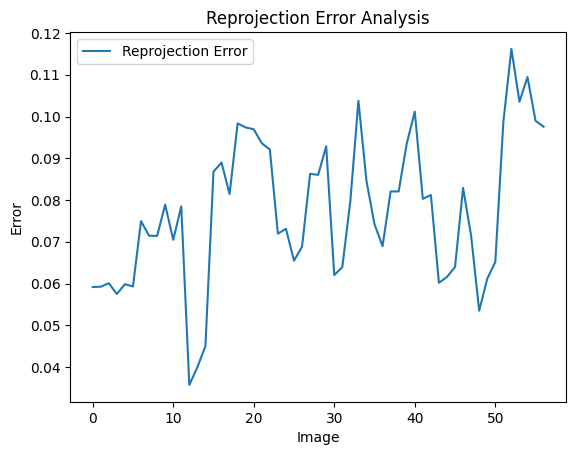

In [ ]:
# plotting the reprojection error data using matplot lib
x_val = [i for i in range(len(err_list))]
plt.plot(x_val, err_list, label = "Reprojection Error")
plt.xlabel('Image')
plt.ylabel('Error')
plt.title("Reprojection Error Analysis")
plt.legend()
plt.show()

 Significance of the reprojection error:

 Reprojection error is an important measure to find the accuracy of the calibrated system. It is also used to tune the parameter of the camera to ensure the quality of the calibration. Its is alos used to reduce the noise in the image.

4. Visualization of Calibration Results:

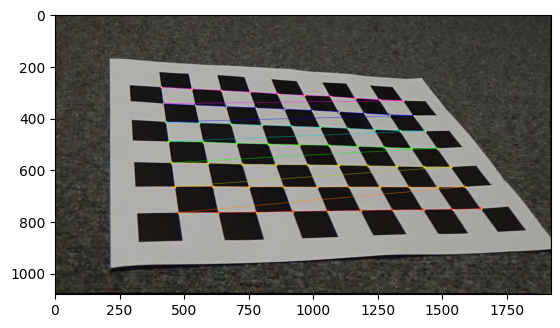

In [ ]:
# comparrision between detected corners before and after calibration
# the undistorted points are shown in yellow
for i in range(len(twod_pts[20])):
  corner_img_vis = cv2.circle(undist_img, (int(twod_pts[20][i][0][0]),int(twod_pts[20][i][0][1])) ,3, (0,255,255), -1)
corner_img_vis= cv2.cvtColor(corner_img_vis, cv2.COLOR_BGR2RGB)
plt.imshow(corner_img_vis)
plt.show()


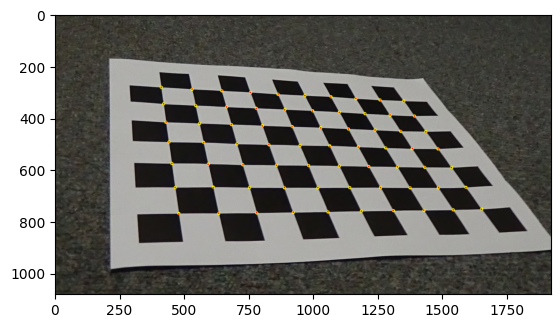

In [ ]:
orig_img = unblurr_wo_corner[20]
for i in range(len(twod_pts[20])):
  corner_img_vis = cv2.circle(orig_img, (int(twod_pts[20][i][0][0]),int(twod_pts[20][i][0][1])) ,6, (0,255,255), -1)
  corner_img_vis = cv2.circle(orig_img, (int(proj_pts_list[20][i][0][0]),int(proj_pts_list[20][i][0][1])) ,3, (0,0,255), -1)
corner_img_vis= cv2.cvtColor(corner_img_vis, cv2.COLOR_BGR2RGB)
plt.imshow(corner_img_vis)
plt.show()
# add image topic

Problem 2.

Step1: The features of the two images are extracted and match making of the feature points is done. With that the fundamental matrix is computed.

Step2: Then the camera matrix is extracted from the txt file and the essential matrix is found.

Step3: The essential matrix is decomposed into rotational and translational matrix.

Step4: Then the images are rectified and epilines and points are plotted on those images.

Step5: Finally, the disparity and the depth data is calculated for those images.

Step6: The required visualizations are plotted

1. Calibration:

In [ ]:
# this function finds the matching keypoints of two images and also finds the fundamental matrix
def match(img_1, img_2):
    # declarring the SIFT feature detector
    sift = cv2.SIFT_create()
    keyp1, feat1 = sift.detectAndCompute(img_1, None)
    keyp2, feat2 = sift.detectAndCompute(img_2, None)
    # Declaring the matcher function
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(feat1, feat2, k=2)
    matches_list = []
    # Filtering the good matches
    for a, b in matches:
        if a.distance < 0.75 * b.distance:
            matches_list.append(a)
    pt_A = np.float32([keyp1[a.queryIdx].pt for a in matches_list]).reshape(-1, 1, 2)
    pt_B = np.float32([keyp2[a.trainIdx].pt for a in matches_list]).reshape(-1, 1, 2)
    # Estimate Fundamental matrix using RANSAC
    Fund, mask = cv2.findFundamentalMat(pt_A, pt_B, cv2.FM_RANSAC)
    return Fund, pt_A, pt_B

In [ ]:
# storing all the images in a list and also reads the text file and saves in a dictionary
os.chdir("/content/drive/My Drive/ENPM673/Proj_3/problem2_dataset")
items = os.listdir()
imgs = []
essen_mat = []
fun_mat = []
A_pt = []
B_pt = []
txt_data = []
order = ["Classroom", "Storageroom", "Traproom"]
for i in range(3):
  items1 = os.listdir(items[i])
  for j in range(3):
    txt = "/content/drive/My Drive/ENPM673/Proj_3/problem2_dataset"+"/"+items[i]+"/"+items1[j]
    if j!=2:
      # print(i)
      img = cv2.imread(txt)
      imgs.append(img)
    else:
      with open(txt, 'r') as f:
        data = {}
        for line in f:
          key, value = line.strip().split('=')
          data[key] = value
  # calling the match function to get the fundamental natrix and keypoints
  fund_mat, pt_A, pt_B = match(cv2.cvtColor(imgs[(i*2)], cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgs[(i*2)+1], cv2.COLOR_BGR2GRAY),)
  txt_data.append(data)
  fun_mat.append(fund_mat)
  A_pt.append(pt_A)
  B_pt.append(pt_B)
  print("Fundamental matrix of",order[i],":\n",fund_mat)
  print("--------")
# print(txt_data)

Fundamental matrix of Classroom :
 [[-6.37564541e-09 -4.34894950e-06  8.41027473e-03]
 [ 4.14775720e-06  1.51964048e-07  1.70201604e-01]
 [-8.21242321e-03 -1.69795303e-01  1.00000000e+00]]
--------
Fundamental matrix of Storageroom :
 [[ 6.69597564e-08 -1.02393112e-04  7.68347200e-02]
 [ 1.02345426e-04  3.44559007e-07 -6.64516847e-01]
 [-7.70820673e-02  6.61630761e-01  1.00000000e+00]]
--------
Fundamental matrix of Traproom :
 [[ 4.39892156e-08  1.74912265e-05 -2.31409122e-03]
 [-1.95713852e-05  5.96141733e-06 -2.57545139e-01]
 [ 3.27633547e-03  2.53825368e-01  1.00000000e+00]]
--------


In [ ]:
# finding the essential matrix by forming the camera matrix from the text and takeing dot product of these matrix
for i in range(3):
  ptA = A_pt[i]
  ptB = B_pt[i]
  fm = fun_mat[i]
  data = txt_data[0]
  camera_1 = str(data.get('cam0'))
  camera_2 = str(data.get('cam1'))
  # camera matrix from txt file
  cam_1 = np.array([[float(camera_1[1:8]), 0, float(camera_1[11:16])],
                [0, float(camera_1[1:8]), float(camera_1[28:34])],
                [0, 0, 1]])
  cam_2 = np.array([[float(camera_2[1:8]), 0, float(camera_2[11:16])],
                [0, float(camera_2[1:8]), float(camera_2[28:34])],
                [0, 0, 1]])
  ess = np.dot(np.dot(cam_2.T, fm), cam_1)
  # the essential matrix is decomposed to get rotational and translational matrix
  _,rot_matrix, trans_matrix,_ = cv2.recoverPose(ess, ptA, ptB)
  print("Essential matrix of",order[i],":\n", ess)
  print("Rotational matrix of",order[i],":\n", rot_matrix)
  print("Translational matrix of ",order[i],":\n", trans_matrix)
  print("------------")

Essential matrix of Classroom :
 [[-1.94416007e-02 -1.32614872e+01  1.06299958e+01]
 [ 1.26479806e+01  4.63392199e-01  2.97462360e+02]
 [-1.04724798e+01 -2.96474619e+02  1.26170449e+00]]
Rotational matrix of Classroom :
 [[ 9.99997538e-01  1.69572351e-04  2.21258966e-03]
 [-1.63059685e-04  9.99995655e-01 -2.94330684e-03]
 [-2.21307915e-03  2.94293881e-03  9.99993221e-01]]
Translational matrix of  Classroom :
 [[-0.99836935]
 [ 0.03548767]
 [ 0.04471313]]
------------
Essential matrix of Storageroom :
 [[ 2.04184010e-01 -3.12232860e+02  3.86731587e+01]
 [ 3.12087448e+02  1.05068243e+00 -1.15742518e+03]
 [-3.91460828e+01  1.15302688e+03 -4.47238456e-01]]
Rotational matrix of Storageroom :
 [[ 9.99999164e-01  7.83272580e-04 -1.02884592e-03]
 [-7.83166336e-04  9.99999688e-01  1.03663650e-04]
 [ 1.02892679e-03 -1.02857805e-04  9.99999465e-01]]
Translational matrix of  Storageroom :
 [[-0.96474483]
 [-0.03213417]
 [-0.26121791]]
------------
Essential matrix of Traproom :
 [[ 1.34138697e-01 

2. Rectification


In [ ]:
# this function plots the epipolar points and lines
def plot_lines(pt_A, pt_B, img_a, img_b, lines):
  img_ac = img_a.copy()
  img_bc = img_b.copy()
  # row,col = imga.shape
  print(len(lines))
  # itterating through each epipolar sets
  for i in range(len(lines)):
    r_cur = lines[i]
    ptA = tuple(pt_A[i][0])
    ptB = tuple(pt_B[i][0])
    clr = tuple(np.random.randint(0,255,3).tolist())
    x_0, y_0 = map(int,[0, -r_cur[2]/r_cur[1]])
    x_1, y_1 = map(int,[img_a.shape[1], -((r_cur[2]+r_cur[0]*img_a.shape[1])) / r_cur[1]])
    img_ac = cv2.line(img_ac, (x_0, y_0), (x_1, y_1), clr, 1)
    img_ac = cv2.circle(img_ac,(int(ptA[0]),int(ptA[1])),5, clr, -1)
    img_bc = cv2.circle(img_bc,(int(ptB[0]),int(ptB[1])), 5,clr, -1)
  return img_ac, img_bc

homogeneous matrix of Traproom :
 [[-1.73752085e-01  3.03544936e-02  6.14475038e+00]
 [-8.10971974e-03 -1.69846916e-01  5.32482288e+00]
 [-4.09346820e-06 -4.56995997e-08 -1.68181815e-01]] 

 [[ 1.01336237e+00 -2.46201901e-02  1.64197011e+01]
 [ 4.85681619e-02  9.99115103e-01 -2.53773065e+01]
 [ 2.52914429e-05 -6.14469364e-07  9.86932511e-01]]
624
624


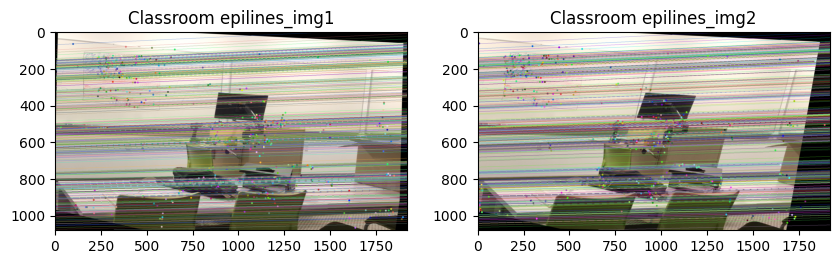

homogeneous matrix of Traproom :
 [[-6.03200952e-01  2.72714826e-02 -3.49606409e+01]
 [ 8.45115743e-02 -6.69452880e-01 -4.33172063e+01]
 [ 1.12281475e-04 -3.62424985e-06 -7.26010208e-01]] 

 [[ 9.08329794e-01 -3.23629120e-02  8.05703070e+01]
 [-1.26235509e-01  1.00513216e+00  6.32402993e+01]
 [-1.68585363e-04  6.00653344e-06  1.08526982e+00]]
2293
2293


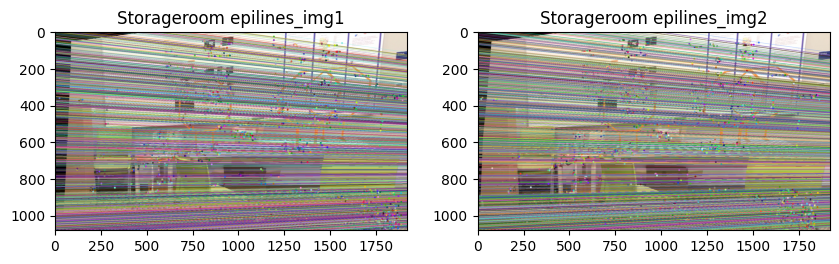

homogeneous matrix of Traproom :
 [[ 2.59296565e-01  3.53864103e-03 -2.26406632e+01]
 [ 3.15269547e-03  2.54377189e-01 -7.11986469e-01]
 [ 1.88182558e-05 -4.81204735e-06  2.47482465e-01]] 

 [[ 1.03417015e+00  5.65336923e-02 -7.27242235e+01]
 [ 8.81303621e-03  1.00197483e+00 -6.65487547e+00]
 [ 6.60388481e-05  3.61006352e-06  9.60873361e-01]]
890
890


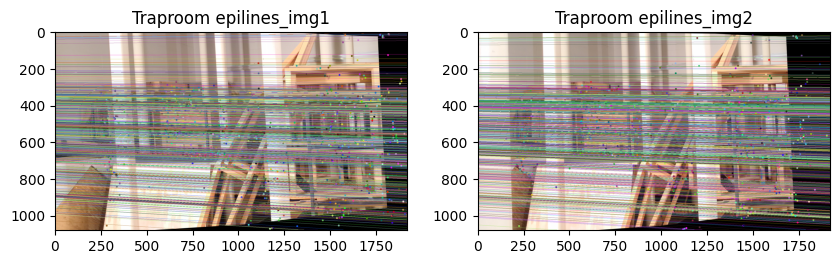

In [ ]:
# the images are rectified and transformed acoording to the homography matrices found
rectified_list = []
for k in range(3):
  fund_mat = fun_mat[k]
  pt_A = A_pt[k]
  pt_B = B_pt[k]
  # print(fund_mat)
  first_ind = k*2
  sec_ind = (k*2)+1
  h1,w1 = imgs[first_ind].shape[:2]
  h2,w2 = imgs[sec_ind].shape[:2]
  #  homography matrices of the images are found
  _, hom_1, hom_2 = cv2.stereoRectifyUncalibrated(pt_A,pt_B,fund_mat, imgs[sec_ind].shape[:2])
  print("homogeneous matrix of",order[i],":\n",hom_1,"\n\n",hom_2)
  img1_rect = cv2.warpPerspective(imgs[first_ind], hom_1, (w1, h1))
  img2_rect = cv2.warpPerspective(imgs[sec_ind], hom_2, (w2, h2))
  rectified_list.append(img1_rect)
  rectified_list.append(img2_rect)

  # epilines are computed and plotted
  lines1 = cv2.computeCorrespondEpilines(pt_B, 2,fund_mat).reshape(-1,3)
  epilines_img1, __ = plot_lines(pt_A, pt_B, img2_rect, img1_rect, lines1)
  lines2 = cv2.computeCorrespondEpilines(pt_A, 1,fund_mat).reshape(-1,3)
  epilines_img2, __ = plot_lines(pt_B, pt_A, img1_rect, img2_rect, lines2)
  epilines_img1= cv2.cvtColor(epilines_img1, cv2.COLOR_BGR2RGB)
  epilines_img2= cv2.cvtColor(epilines_img2, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(epilines_img1)
  plt.title(order[k]+' epilines_img1')
  plt.subplot(1, 2, 2)
  plt.imshow(epilines_img2)
  plt.title(order[k]+' epilines_img2')
  plt.show()

3. Compute Depth Image

a. Classroom

{'cam0': '[1746.24 0 14.88; 0 1746.24 534.11; 0 0 1]', 'cam1': '[1746.24 0 14.88; 0 1746.24 534.11; 0 0 1]', 'doffs': '0', 'baseline': '678.37', 'width': '1920', 'height': '1080', 'ndisp': '310', 'vmin': '60', 'vmax': '280'}


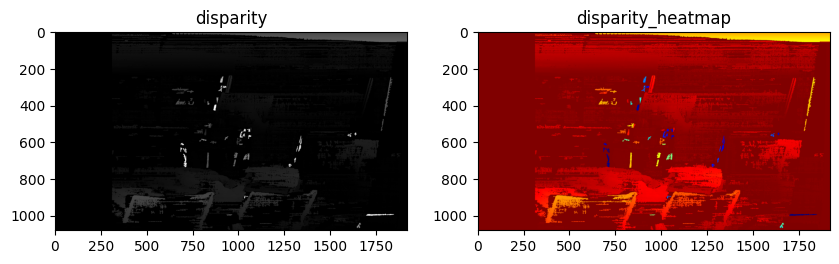

1746.24


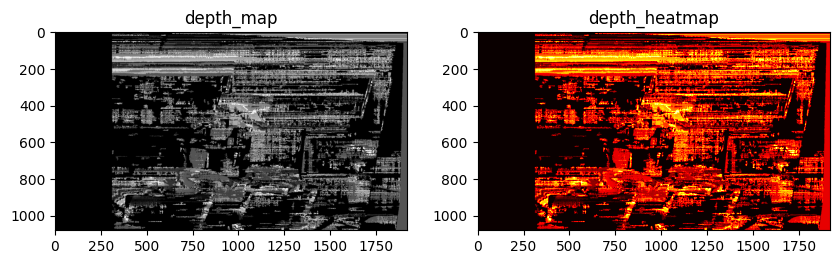

<Figure size 640x480 with 0 Axes>

In [ ]:
# this function computes depth map by dinding the disparity of the images
def disparity(img1, img2):
  img_a = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img_b = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  data = txt_data[0]
  print(data)
  num_disp = int(data.get('ndisp'))
  baseline = float(data.get('baseline'))
  foc = str(data.get('cam0'))
  x = 1
  min_disp = 0
  # finding the stereo matrix
  st = cv2.StereoSGBM_create(minDisparity=min_disp,
                                    numDisparities=num_disp,
                                    blockSize=x,
                                    P1=8*3*x**2,
                                    P2=32*3*x**2,
                                    disp12MaxDiff=1,
                                    uniquenessRatio=10,
                                    speckleWindowSize=100,
                                    speckleRange=2,
                                    preFilterCap=63,
                                    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
  # rescaled disparity map
  disparity = st.compute(img_a, img_b)
  disparity_n = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  heatmap = cv2.applyColorMap(disparity_n, cv2.COLORMAP_JET)

  # plotting the disparity map
  # cv2_imshow(disparity)
  disparity_col = cv2.cvtColor(disparity_n, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(disparity_col)
  plt.title('disparity')
  plt.subplot(1, 2, 2)
  plt.imshow(heatmap)
  plt.title('disparity_heatmap')
  plt.show()

  # finding the depth matrix
  disparity = disparity_n
  baseline = baseline
  focal_len = float(foc[1:8])
  print(focal_len)
  depth_map = np.zeros_like(disparity, dtype=np.uint8)
  # inorder to avoid the zero division error, the disparities above zero value is considered
  depth_map[disparity > 0] = (baseline * focal_len) / disparity[disparity > 0]
  # normalizing depth map
  #depth_map = depth_map / np.max(depth_map)
  depth_map = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # depth_heatmap = cv2.applyColorMap(depth_map, cv2.COLORMAP_JET)

  # plotting the depth map
  # cv2_imshow(depth_map / np.max(depth_map))
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(depth_map, cmap = "gray")
  plt.title('depth_map')
  plt.subplot(1, 2, 2)
  plt.imshow(depth_map, cmap = "hot")
  plt.title('depth_heatmap')
  plt.show()
  plt.savefig('plot_class.png')
  return disparity

disparity = disparity(rectified_list[0], rectified_list[1])
# cv2_imshow(rectified_list[1])

b. Storageroom

{'cam0': '[1742.11 0 804.90; 0 1742.11 541.22; 0 0 1]', 'cam1': '[1742.11 0 804.90; 0 1742.11 541.22; 0 0 1]', 'doffs': '0', 'baseline': '221.76', 'width': '1920', 'height': '1080', 'ndisp': '100', 'vmin': '29', 'vmax': '61'}


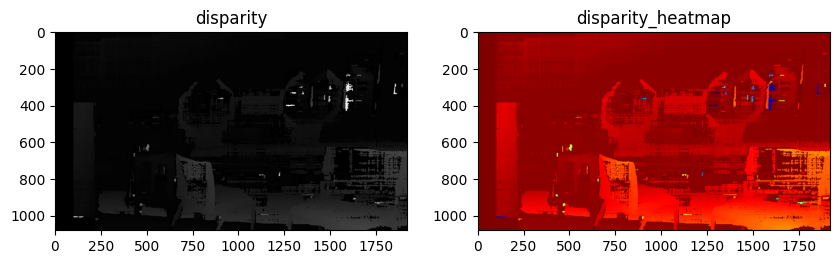

1742.11


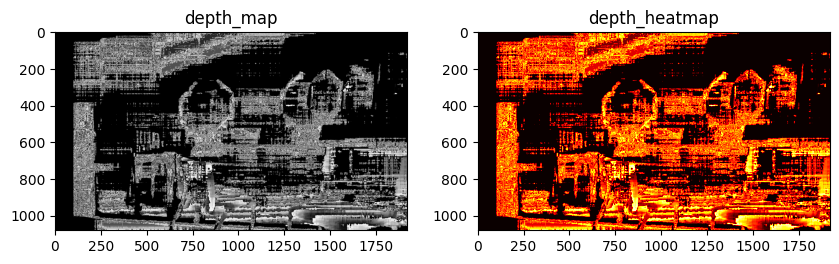

<Figure size 640x480 with 0 Axes>

In [ ]:
# this function computes depth map by dinding the disparity of the images
def disparity(img1, img2):
  img_a = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img_b = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  data = txt_data[1]
  print(data)
  num_disp = int(data.get('ndisp'))
  baseline = float(data.get('baseline'))
  foc = str(data.get('cam0'))
  x = 5
  min_disp = 0
  # finding the stereo matrix
  st = cv2.StereoSGBM_create(minDisparity=min_disp,
                                    numDisparities=num_disp,
                                    blockSize=x,
                                    P1=8*3*x**2,
                                    P2=32*3*x**2,
                                    disp12MaxDiff=1,
                                    uniquenessRatio=10,
                                    speckleWindowSize=100,
                                    speckleRange=2,
                                    preFilterCap=63,
                                    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
  # rescaled disparity map
  disparity = st.compute(img_a, img_b)
  disparity_n = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  heatmap = cv2.applyColorMap(disparity_n, cv2.COLORMAP_JET)

  # plotting the disparity map
  # cv2_imshow(disparity)
  disparity_col = cv2.cvtColor(disparity_n, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(disparity_col)
  plt.title('disparity')
  plt.subplot(1, 2, 2)
  plt.imshow(heatmap)
  plt.title('disparity_heatmap')
  plt.show()

  # finding the depth matrix
  # disparity = st.compute(img_a, img_b)
  baseline = baseline
  focal_len = float(foc[1:8])
  print(focal_len)
  depth_map = np.zeros_like(disparity, dtype=np.uint8)
  # inorder to avoid the zero division error, the disparities above zero value is considered
  depth_map[disparity > 0] = (baseline * focal_len) / disparity[disparity > 0]
  # normalizing depth map
  depth_map = depth_map / np.max(depth_map)
  # depth_map = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # depth_heatmap = cv2.applyColorMap(depth_map, cv2.COLORMAP_JET)

  # plotting the depth map
  # cv2_imshow(depth_map / np.max(depth_map))
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(depth_map, cmap = "gray")
  plt.title('depth_map')
  plt.subplot(1, 2, 2)
  plt.imshow(depth_map, cmap = "hot")
  plt.title('depth_heatmap')
  plt.show()
  plt.savefig('plot_class.png')
  return disparity

disparity = disparity(rectified_list[2], rectified_list[3])
# cv2_imshow(rectified_list[1])

c. Traproom

{'cam0': '[1769.02 0 1271.89; 0 1769.02 527.17; 0 0 1]', 'cam1': '[1769.02 0 1271.89; 0 1769.02 527.17; 0 0 1]', 'doffs': '0', 'baseline': '295.44', 'width': '1920', 'height': '1080', 'ndisp': '140', 'vmin': '25', 'vmax': '118'}


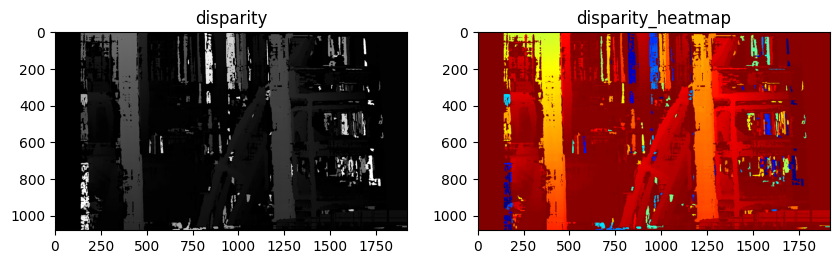

1769.02


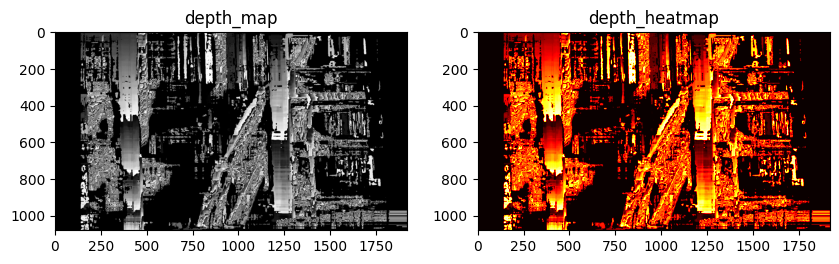

<Figure size 640x480 with 0 Axes>

In [ ]:
# this function computes depth map by dinding the disparity of the images
def disparity(img1, img2):
  img_a = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img_b = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  data = txt_data[2]
  print(data)
  num_disp = int(data.get('ndisp'))
  baseline = float(data.get('baseline'))
  foc = str(data.get('cam0'))
  x = 9
  min_disp = 0
  # finding the stereo matrix
  st = cv2.StereoSGBM_create(minDisparity=min_disp,
                                    numDisparities=num_disp,
                                    blockSize=x,
                                    P1=8*3*x**2,
                                    P2=32*3*x**2,
                                    disp12MaxDiff=1,
                                    uniquenessRatio=10,
                                    speckleWindowSize=100,
                                    speckleRange=2,
                                    preFilterCap=63,
                                    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
  # rescaled disparity map
  disparity = st.compute(img_a, img_b)
  disparity_n = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  heatmap = cv2.applyColorMap(disparity_n, cv2.COLORMAP_JET)

  # plotting the disparity map
  # cv2_imshow(disparity)
  disparity_col = cv2.cvtColor(disparity_n, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(disparity_col)
  plt.title('disparity')
  plt.subplot(1, 2, 2)
  plt.imshow(heatmap)
  plt.title('disparity_heatmap')
  plt.show()

  # finding the depth matrix
  # disparity = st.compute(img_a, img_b)
  baseline = baseline
  focal_len = float(foc[1:8])
  print(focal_len)
  depth_map = np.zeros_like(disparity, dtype=np.uint8)
  # inorder to avoid the zero division error, the disparities above zero value is considered
  depth_map[disparity > 0] = (baseline * focal_len) / disparity[disparity > 0]
  # normalizing depth map
  depth_map = depth_map / np.max(depth_map)
  # depth_map = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # depth_heatmap = cv2.applyColorMap(depth_map, cv2.COLORMAP_JET)

  # plotting the depth map
  # cv2_imshow(depth_map / np.max(depth_map))
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(depth_map, cmap = "gray")
  plt.title('depth_map')
  plt.subplot(1, 2, 2)
  plt.imshow(depth_map, cmap = "hot")
  plt.title('depth_heatmap')
  plt.show()
  plt.savefig('plot_class.png')
  return disparity

disparity = disparity(rectified_list[4], rectified_list[5])
# cv2_imshow(rectified_list[1])